To launch in SuperCloud from a Computed Node

LLsub -i full #for an exclusive node

LLsub -i -s 40 #for node with 40 CPUs

LLsub -i -s 40 -g volta:1 #for node with 40 CPUs and 1 Volta GPU

salloc  --job-name=interactive --qos=high --time=02:00:00 --partition=debug-gpu --gres=gpu:volta:2 --cpus-per-task=40 srun    --pty bash -i

salloc  --job-name=interactive --qos=high --time=02:00:00 --partition=debug-cpu --cpus-per-task=40 srun  --pty bash -i

LLsub -i full

module load anaconda/2023a-pytorch

jupyter lab --no-browser --ip=0.0.0.0 --port=8890



In [1]:
import os

# Hard-cap math libs to 1 thread per process
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"

# Prevent jemalloc from trying to start background threads
# (Some systems use JE_MALLOC_CONF; both are harmless if not present.)
os.environ.setdefault("MALLOC_CONF", "background_thread:false")
os.environ.setdefault("JE_MALLOC_CONF", "background_thread:false")

'background_thread:false'

In [2]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dgd.utils.utils5 import *
from dgd.utils.nnassignments import *
from dgd.utils.verification import *
import pickle
import pandas as pd
import json
import networkx as nx
from tqdm.notebook import tqdm
import time
import subprocess
import multiprocessing as mp
import random
from collections import defaultdict
import socket
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import cycle
from pathlib import Path
import time
from sklearn.metrics import mean_squared_error, r2_score
import csv
import math
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D  
import re, platform
from datetime import datetime       

In [3]:
t_total_start = time.perf_counter()

In [4]:
#Set seed
global_seed = int.from_bytes(os.urandom(4), "little")
print(f"Generated random seed {global_seed}")
random.seed(global_seed)            
np.random.seed(global_seed)
th.manual_seed(global_seed)    

Generated random seed 3155269583


In [5]:
hostname = socket.gethostname()
print(f"Node: {hostname}")
num_gpus = th.cuda.device_count()
print(f"GPUs: {num_gpus}")
for idx in range(num_gpus):
    props = th.cuda.get_device_properties(idx)
    print(f"GPU {idx}: {props.name} "
          f"({props.total_memory // 1024**2} MB, "
          f"compute capability {props.major}.{props.minor})")
print(f"CPUs in compute node: {multiprocessing.cpu_count()}")

CPUs_alloc = len(os.sched_getaffinity(0)) if hasattr(os, "sched_getaffinity") else int(os.environ.get("SLURM_CPUS_PER_TASK", os.cpu_count() or 1))
print(f"CPUs allocated: {CPUs_alloc}")

Node: login-2
GPUs: 0
CPUs in compute node: 64
CPUs allocated: 64


#### Parameters

In [6]:
circuit_name = "0x17"

#File with designs 
#file_name = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/exp/scratch_training/0x2B/seed_1/optimal_topologies/optimal_topologies.pkl"
file_name = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/scratch_training/3in_registry_processed_old/{circuit_name}/seed_1/optimal_topologies/optimal_topologies.pkl"
             
#file_name = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/exp/scratch_training/{circuit_name}/seed_1/optimal_topologies/optimal_topologies.pkl"

# Set up output directory
output_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/stratch/SA"

Path(output_dir).mkdir(parents=True, exist_ok=True)


In [7]:
selected_graph = 0

permutation_index = 0

In [8]:
with open(file_name, "rb") as f:
    reduced_graphs = pickle.load(f)   
 
print(f"Number of biological circuits: {len(reduced_graphs)}")

Number of biological circuits: 6


In [9]:
type(reduced_graphs)

list

In [10]:
#Plot biological circuit designs
for idx, biological_circuit in enumerate(reduced_graphs):
    print(f"Circuit design {idx}")
    #small_topology_plot(biological_circuit)
    plot_circuit_layered(biological_circuit, show_in_notebook=True, notebook_width = 500, save = False) 

Circuit design 0


Circuit design 1


Circuit design 2


Circuit design 3


Circuit design 4


Circuit design 5


In [11]:
#Select graph in graphs
#0x2B


#selected_graph = 3  #for 0x17

#selected_graph = 0  #for 0x6D

#It will compute valid permutations if True, otherwise it will try to load a prior computation    
compute_valid_permutations = False

In [12]:
topology_networkx = reduced_graphs[selected_graph] 

In [13]:
topology_networkx = reduced_graphs[selected_graph] 

# Define the input nodes
input_nodes = [node for node in topology_networkx.nodes() if topology_networkx.in_degree(node) == 0]
# Generate all permutations of the input nodes
permutations = list(itertools.permutations(input_nodes))
# Create a list to store the permuted graphs
permuted_graphs = []

for perm in permutations:
    new_graph = permute_graph(topology_networkx, perm, input_nodes)

    if calculate_truth_table_v2(new_graph) == calculate_truth_table_v2(topology_networkx):
        idx = len(permuted_graphs)          
        print(f"Permuted graphs {idx}: {perm}")      
        permuted_graphs.append(new_graph)  
        

Permuted graphs 0: (2, 1, 0)
Permuted graphs 1: (2, 0, 1)
Permuted graphs 2: (1, 2, 0)
Permuted graphs 3: (1, 0, 2)
Permuted graphs 4: (0, 2, 1)
Permuted graphs 5: (0, 1, 2)


Base circuit design


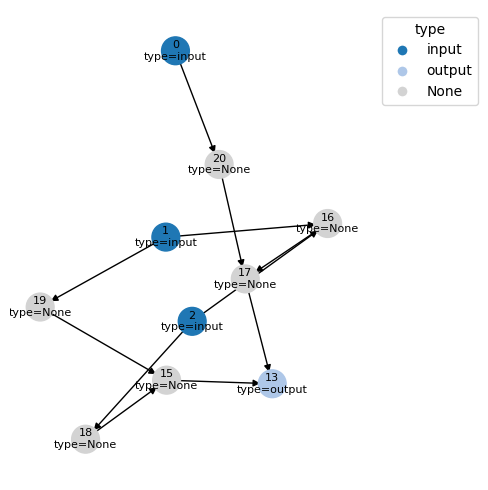

Permutation 0


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 1


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 2


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 3


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 4


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}
Permutation 5


{'ok': True, 'inputs': [0, 1, 2], 'outputs': [13], 'errors': [], 'warnings': []}


In [14]:
print(f"Base circuit design")
topology_plot_with_attrs(topology_networkx, seed = 1459)

for idx, topology_permutation in enumerate(permuted_graphs):
    print(f"Permutation {idx}")
    #small_topology_plot(topology_permutation) 
    plot_circuit_layered(topology_permutation, show_in_notebook=True, notebook_width = 500, save = False) 
    result = validate_dag(topology_permutation, 1, raise_on_error=True, plot_on_error=True)
    print(result)


In [15]:
for nodes in topology_networkx.nodes(data = True):
    print(nodes)

(2, {'type': 'input'})
(1, {'type': 'input'})
(0, {'type': 'input'})
(13, {'type': 'output'})
(15, {})
(16, {})
(17, {})
(18, {})
(19, {})
(20, {})


## Import experimental data

In [16]:
input_signals_list_small_molecules, input_names, _ , _ = load_input_data("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/input_data_3_inputs_POSTECH.json")
for row in input_signals_list_small_molecules:
    print(row)

{0: 0.0278, 1: 0.0022, 2: 0.0042}
{0: 0.0278, 1: 0.0022, 2: 2.0082}
{0: 0.0278, 1: 5.0543, 2: 0.0042}
{0: 0.0278, 1: 5.0543, 2: 2.0082}
{0: 3.9239, 1: 0.0022, 2: 0.0042}
{0: 3.9239, 1: 0.0022, 2: 2.0082}
{0: 3.9239, 1: 5.0543, 2: 0.0042}
{0: 3.9239, 1: 5.0543, 2: 2.0082}


In [17]:
input_signals_list_binary = binary_truth_table(len(input_signals_list_small_molecules[0]))
for row in input_signals_list_binary:
    print(row)

{0: 0, 1: 0, 2: 0}
{0: 0, 1: 0, 2: 1}
{0: 0, 1: 1, 2: 0}
{0: 0, 1: 1, 2: 1}
{0: 1, 1: 0, 2: 0}
{0: 1, 1: 0, 2: 1}
{0: 1, 1: 1, 2: 0}
{0: 1, 1: 1, 2: 1}


In [18]:
# Load the part response experimental data
with open("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/response_data_POSTECH.json") as f:
    repressor_data = json.load(f)

# Create DataFrame
postech_v1_hill_function_parameters = pd.DataFrame(repressor_data)

postech_v1_hill_function_parameters

protein_groups = [
    {3, 4, 5},
    {10, 11, 12},
    {14, 15},
    {16, 17, 18, 19},
]

# Load cell growth experimental data
file_path = '/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/growth_data_POSTECH.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract all gate toxicity data
gate_toxicity_data = [item for item in data if item.get("collection") == "gate_toxicity"]

# Convert the list of dictionaries into a DataFrame
gate_toxicity_df = pd.DataFrame(gate_toxicity_data)

# show up to 10 decimal places; adjust as you like
pd.set_option("display.float_format", "{:.10f}".format)

postech_v1_hill_function_parameters


,Repressor,RBS,ymaxa,ymina,Ka,n,Toxicity (RPU)
0,AmeR,F1,3.8350000000,1.0600000000,0.1220000000,1.3060000000,-
1,AmtR,A1,5.0360000000,0.0910000000,0.0220000000,1.3080000000,-
2,BetI,E1,3.0650000000,0.0000000000,0.3630000000,1.8330000000,-
3,BM3R1,B1,0.5430000000,0.0020000000,0.0510000000,2.0420000000,-
4,BM3R1,B2,0.8220000000,0.0000000000,0.2850000000,1.6850000000,-
5,BM3R1,B3,0.7040000000,0.0000000000,0.2610000000,1.7680000000,-
6,HlyIIR,H1,2.4620000000,0.0570000000,0.0000000000,2.5960000000,4.0652500000
7,IcaRA,I1,3.5580000000,0.0000000000,0.1860000000,1.0850000000,0.4709400000
8,LitR,L1,4.2960000000,0.0740000000,0.0000000000,1.6960000000,-
9,LmrA,N1,2.1520000000,0.1830000000,0.0000000000,2.0950000000,-


In [19]:
gate_toxicity_df

,collection,gate_name,input,growth
0,gate_toxicity,F1_AmeR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.936601827, 0.929528441, 0.927586207, 0.9..."
1,gate_toxicity,A1_AmtR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.005567327, 0.987403446, 1.01189251, 1.01..."
2,gate_toxicity,E1_BetI,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.465830721, 1.017868339, 1.023301985, 1.0..."
3,gate_toxicity,B1_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.992753623, 0.971014493, 0.992914654, 0.9..."
4,gate_toxicity,B2_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.978445044, 1.001274554, 1.019855551, 0.9..."
5,gate_toxicity,B3_BM3R1,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.971657754, 0.970707071, 1.015062389, 0.9..."
6,gate_toxicity,H1_HlyIIR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.931501911, 0.945850458, 0.941163746, 0.9..."
7,gate_toxicity,I1_IcaRA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.019887906, 1.026628502, 1.028642482, 1.0..."
8,gate_toxicity,L1_LitR,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 1.034190532, 1.017241379, 1.034190532, 1.0..."
9,gate_toxicity,N1_LmrA,"[0.00422, 0.00497, 0.009, 0.0142, 0.05441, 0.1...","[1, 0.948325359, 0.884901648, 0.884237108, 0.8..."


### Adquire data from objective objective function 

#### Load possible permutations without repeating repressor

In [20]:
gate_count, info = energy_score(topology_networkx, check_implicit_OR_existence_v3)
print(f"Gate count: {gate_count}")
print(f"Info: {info}")

Gate count: 6
Info: {'num_nodes': 10, 'num_inputs': 3, 'num_outputs': 1, 'max_removal': 0, 'best_pattern_key': None}


In [21]:
DATA_DIR = Path("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data")  
                 
file_path = DATA_DIR / "gate_permutations" / f"valid_permutations_{gate_count}_gates.h5"

list_of_gates_indices = list(range(len(postech_v1_hill_function_parameters)))
if compute_valid_permutations:
    print("Computing valid gate permutations")
    valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
    save_valid_permutations(valid_permutations, file_path)
else:
    if file_path.is_file():           
        print(f"Found: {file_path}")
        print("Loading valid gate permutations")
        valid_permutations = load_valid_permutations(file_path)
        
    else:
        print(f"Missing: {file_path}")
        print("Computing valid gate permutations because file does not exist")   
        valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
        save_valid_permutations(valid_permutations, file_path)   
        
print(f"Total valid permutations: {len(valid_permutations)}")
print("Example permutation:", valid_permutations[0] if valid_permutations else "No permutations found")

Found: /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/gate_permutations/valid_permutations_6_gates.h5
Loading valid gate permutations
Total valid permutations: 8739360
Example permutation: (0, 1, 2, 3, 6, 7)


#### Set adj matrix 

In [22]:
Gi = permuted_graphs[permutation_index]
list(Gi.nodes(data = True))

[(2, {'type': 'input'}),
 (1, {'type': 'input'}),
 (0, {'type': 'input'}),
 (13, {'type': 'output'}),
 (15, {}),
 (16, {}),
 (17, {}),
 (18, {}),
 (19, {}),
 (20, {})]

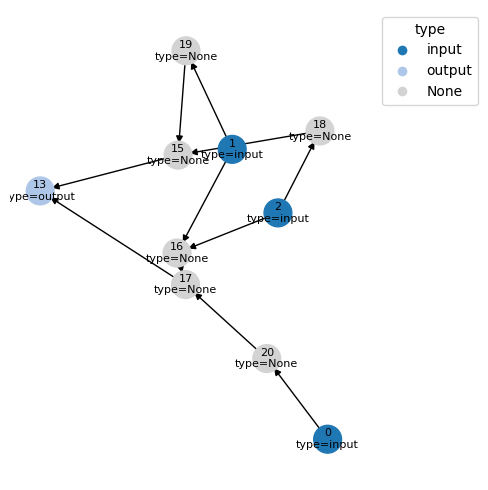

In [23]:
topology_plot_with_attrs(Gi)

In [24]:
nodelist = sorted(Gi.nodes())
list(sorted(Gi.nodes(data = True)))

[(0, {'type': 'input'}),
 (1, {'type': 'input'}),
 (2, {'type': 'input'}),
 (13, {'type': 'output'}),
 (15, {}),
 (16, {}),
 (17, {}),
 (18, {}),
 (19, {}),
 (20, {})]

In [25]:
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()
adj_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

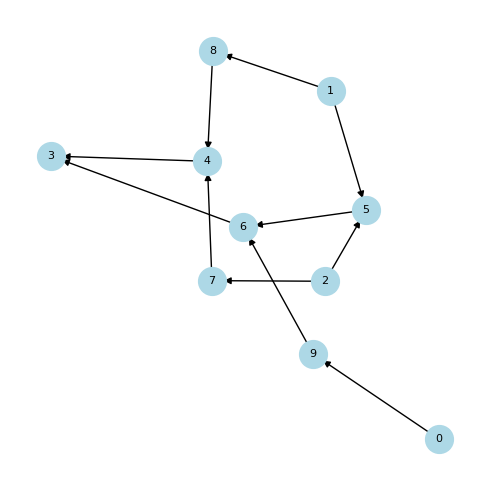

In [26]:
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Remove disconnected nodes (nodes with neither incoming nor outgoing edges)
disconnected_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
G.remove_nodes_from(disconnected_nodes)
topology_plot_with_attrs(G)

In [27]:
input_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]
output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

# Filter nodes that are neither inputs nor outputs
non_io_nodes = [node for node in G.nodes() if node not in input_nodes and node not in output_nodes]
non_io_nodes

[4, 5, 6, 7, 8, 9]

In [28]:
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

Save metadata

In [ ]:
def _slug(x) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", str(x))

# Build metadata strictly from existing variables
metadata = {
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "seed": global_seed,                 # from your block
    "node": hostname,                    # from your block
    "cpu": {
        "cpus_total": mp.cpu_count(),
        "cpus_allocated": CPUs_alloc,   # from your block
    },
    "gpu": {
        "num_gpus": num_gpus,           # from your block
    },
    "versions": {
        "python": platform.python_version(),
        "numpy": np.__version__,
        "torch": th.__version__,
    },
    "env": {
        "SLURM_JOB_ID": os.environ.get("SLURM_JOB_ID"),
        "SLURM_PROCID": os.environ.get("SLURM_PROCID"),
        "SLURM_NTASKS": os.environ.get("SLURM_NTASKS"),
        "SLURM_CPUS_PER_TASK": os.environ.get("SLURM_CPUS_PER_TASK"),
        "HOSTNAME": os.environ.get("HOSTNAME"),
    },
    # New: experiment/context fields from variables you set above this snippet
    "experiment": {
        "circuit_name": circuit_name,               # e.g., "0x17"
        "file_name": file_name,                     # path to designs .pkl
        "output_dir": output_dir,                   # base output dir
        # Include these if they exist in your run context
        "selected_graph": selected_graph if 'selected_graph' in globals() else None,
        "permutation_index": permutation_index if 'permutation_index' in globals() else None,
    },
}

# Save path per your spec:
# Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/run_metadata_{circuit_name}_{selected_graph}_{permutation_index}.json"
_safe_circuit = _slug(circuit_name)
_safe_graph = _slug(selected_graph) if 'selected_graph' in globals() else "NA"
_safe_perm = _slug(permutation_index) if 'permutation_index' in globals() else "NA"

_base = Path(output_dir) / f"{_safe_circuit}_design_{_safe_graph}_permutation_{_safe_perm}"
_base.mkdir(parents=True, exist_ok=True)

_save_path = _base / f"run_metadata_{_safe_circuit}_{_safe_graph}_{_safe_perm}.json"
with open(_save_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, sort_keys=True)

print(f"[metadata] wrote to {_save_path}")

In [ ]:
load_saved_seed = True


if load_saved_seed:   

    _base = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}"
    metadata_path = _base / f"run_metadata_{circuit_name}_{selected_graph}_{permutation_index}.json"

    if load_saved_seed:
        with open(metadata_path, "r", encoding="utf-8") as f:
            global_seed = int(json.load(f)["seed"])

        # Set seed (exactly as original)
        print(f"Loaded random seed {global_seed}")
        random.seed(global_seed)
        np.random.seed(global_seed)
        th.manual_seed(global_seed)

## Simulated annealing

Cello 2 parameters

In [ ]:
'''
saved_run_results = []
run_number = []
num_runs = 3
top_circuit_score = 0
top_toxicity_score = 0
top_solution = 0

for run in range(0, num_runs):
    initial_solution = random_part_selection(postech_v1_hill_function_parameters, gate_count)
    MAXTEMP = 100.0
    MINTEMP = 0.001
    steps = 600
    T0_steps = 100

    optimized_score, optimal_toxicty, optimal_solution = simulated_annealing_cello2(
        adj_matrix, initial_solution, MAXTEMP, MINTEMP, steps, T0_steps,
        input_signals_list_small_molecules, input_signals_list_binary,
        postech_v1_hill_function_parameters, gate_toxicity_df, D_GROWTH_THRESHOLD=0.75)

    saved_run_results.append(optimized_score)
    run_number.append(run)
    
    if optimized_score > top_circuit_score:
        top_circuit_score = optimized_score
        top_toxicity_score = optimal_toxicty
        top_solution = optimal_solution

# Plotting iterations vs highest score
plt.figure(figsize=(8, 4))
plt.scatter(run_number, saved_run_results, color='b')
plt.title('Iterations vs Highest Score')
plt.xlabel('Iteration')
plt.ylabel('Circuit Score')
plt.show()
'''

Steps estimate

In [29]:
import os, random, time
import numpy as np

# ---- assumes these names already exist in your environment ----
# simulated_annealing_cello2, adj_matrix, postech_v1_hill_function_parameters,
# gate_count, input_signals_list_small_molecules, input_signals_list_binary,
# gate_toxicity_df, random_part_selection

MINTEMP = 1e-3
MAXTEMPS = [1, 10, 100]
T0_steps = 10
N_SEEDS = 3
N_INITIALS = 1

TIME_BUDGET_PER_RUN_S = 550  # target wall-clock per (seed × init × MAXTEMP)
WARMUP_STEPS = 300               # short probe length
MAX_STEPS_CAP = int(2e7)         # safety cap (optional)

# ----------------------------------------------------
# Draw N_SEEDS random seeds (independent of initial states)
# ----------------------------------------------------
seeds = [int.from_bytes(os.urandom(4), "little") for _ in range(N_SEEDS)]

# ----------------------------------------------------
# Precompute N_INITIALS random initial solutions ONCE
# ----------------------------------------------------
tmp_seed_for_initials = int.from_bytes(os.urandom(4), "little")
random.seed(tmp_seed_for_initials)
np.random.seed(tmp_seed_for_initials)

initial_solutions = []
for i in range(N_INITIALS):
    init_sol = random_part_selection(postech_v1_hill_function_parameters, gate_count)
    initial_solutions.append(init_sol)

# ---------- helper: keep probe from changing RNG state ----------
def _snapshot_rng():
    return (random.getstate(), np.random.get_state())

def _restore_rng(py_state, np_state):
    random.setstate(py_state)
    np.random.set_state(np_state)

def estimate_steps_for_budget(
    adj_matrix,
    initial_solution,
    MAXTEMP, MINTEMP,
    T0_steps,
    input_signals_list_small_molecules,
    input_signals_list_binary,
    postech_v1_hill_function_parameters,
    gate_toxicity_df,
    D_GROWTH_THRESHOLD,
    warmup_steps=500,
    budget_s=300
):
    """Run a short warmup to estimate avg step time, then return steps ≈ budget/avg_step.
       RNG state is preserved so a later real run would be reproducible."""
    py_state, np_state = _snapshot_rng()

    t0 = time.perf_counter()
    # IMPORTANT: positional args match your original call order
    simulated_annealing_cello2(
        adj_matrix,
        initial_solution,
        MAXTEMP, MINTEMP,
        warmup_steps, T0_steps,
        input_signals_list_small_molecules,
        input_signals_list_binary,
        postech_v1_hill_function_parameters,
        gate_toxicity_df,
        D_GROWTH_THRESHOLD=D_GROWTH_THRESHOLD,
        plot=False
    )
    t1 = time.perf_counter()

    _restore_rng(py_state, np_state)

    avg_step_s = max(1e-9, (t1 - t0) / warmup_steps)
    est_steps = max(1, min(int(budget_s / avg_step_s), MAX_STEPS_CAP))
    return est_steps

# ---------- only print the estimated steps ----------
STEP_CACHE = {}  # cache per MAXTEMP (or use (init_id, maxt) if needed)

for seed in seeds:
    random.seed(seed)
    np.random.seed(seed)

    for init_id, initial_solution in enumerate(initial_solutions):
        for maxt in MAXTEMPS:
            cache_key = maxt
            if cache_key not in STEP_CACHE:
                STEP_CACHE[cache_key] = estimate_steps_for_budget(
                    adj_matrix,
                    initial_solution,
                    maxt, MINTEMP,
                    T0_steps,
                    input_signals_list_small_molecules,
                    input_signals_list_binary,
                    postech_v1_hill_function_parameters,
                    gate_toxicity_df,
                    D_GROWTH_THRESHOLD=0.75,
                    warmup_steps=WARMUP_STEPS,
                    budget_s=TIME_BUDGET_PER_RUN_S
                )

            est_steps = STEP_CACHE[cache_key]
            print(f"seed={seed} init_id={init_id} MAXTEMP={maxt} -> estimated steps={est_steps}")


Optimizing: 100%|██████████| 310/310 [00:15<00:00, 19.52it/s]


seed=2670831758 init_id=0 MAXTEMP=1 -> estimated steps=10343


Optimizing: 100%|██████████| 310/310 [00:16<00:00, 18.31it/s]


seed=2670831758 init_id=0 MAXTEMP=10 -> estimated steps=9732


Optimizing: 100%|██████████| 310/310 [00:16<00:00, 18.38it/s]

seed=2670831758 init_id=0 MAXTEMP=100 -> estimated steps=9765
seed=2938007716 init_id=0 MAXTEMP=1 -> estimated steps=10343
seed=2938007716 init_id=0 MAXTEMP=10 -> estimated steps=9732
seed=2938007716 init_id=0 MAXTEMP=100 -> estimated steps=9765
seed=1960224728 init_id=0 MAXTEMP=1 -> estimated steps=10343
seed=1960224728 init_id=0 MAXTEMP=10 -> estimated steps=9732
seed=1960224728 init_id=0 MAXTEMP=100 -> estimated steps=9765


Cello 2 parameters and more, including random seed

In [31]:
#total = round(len(valid_permutations)*percentage)  
total = 10500

Optimizing: 100%|██████████| 10500/10500 [09:05<00:00, 19.26it/s]


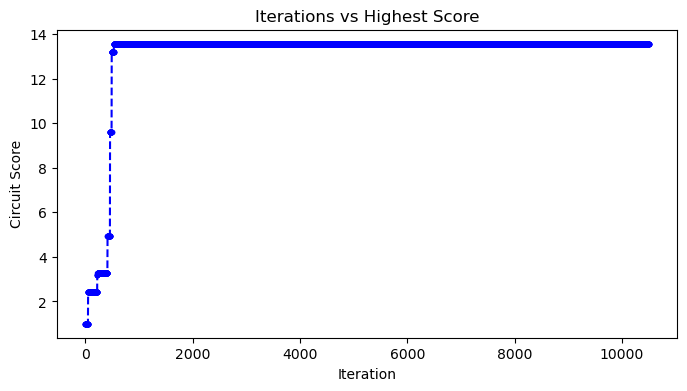

Run time: 545.4465607240563


Optimizing: 100%|██████████| 10500/10500 [09:32<00:00, 18.33it/s]


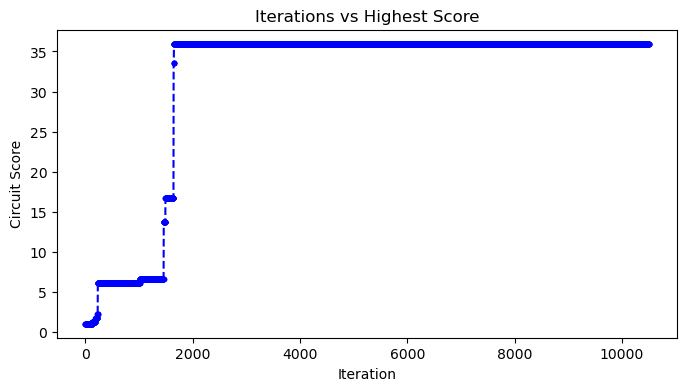

Run time: 572.9738183680456


Optimizing: 100%|██████████| 10500/10500 [09:01<00:00, 19.38it/s]


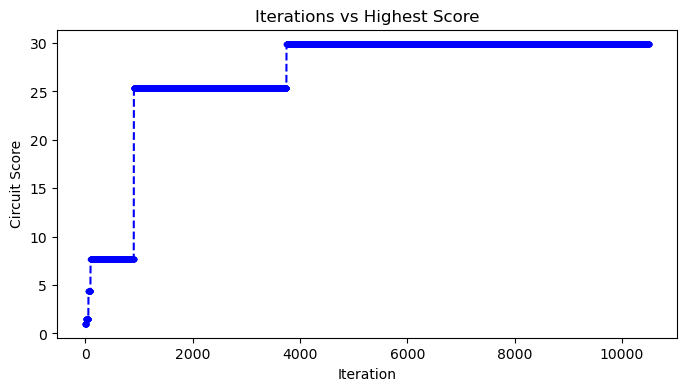

Run time: 542.1319213319803


Optimizing: 100%|██████████| 10500/10500 [08:57<00:00, 19.54it/s]


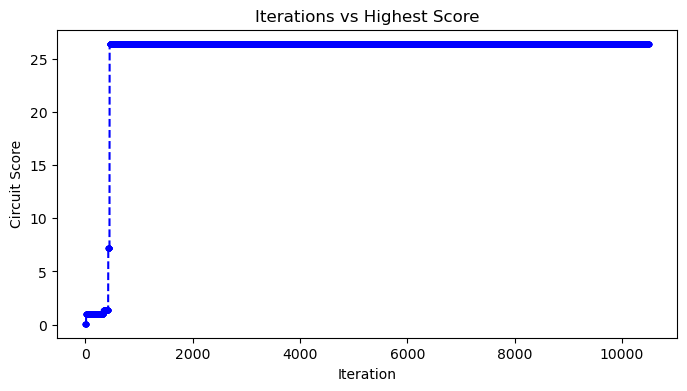

Run time: 537.4603517339565


Optimizing: 100%|██████████| 10500/10500 [09:05<00:00, 19.26it/s]


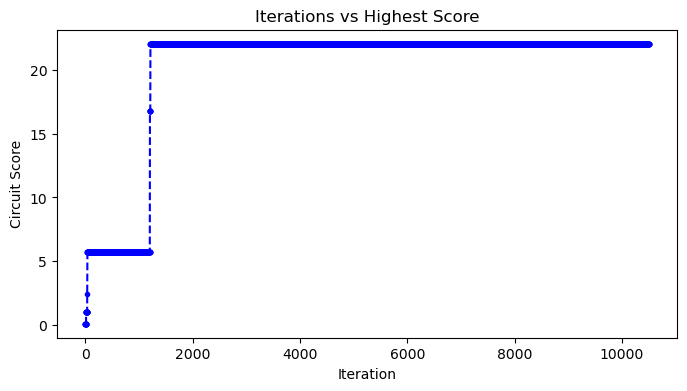

Run time: 545.2760023929877


Optimizing: 100%|██████████| 10500/10500 [08:55<00:00, 19.60it/s]


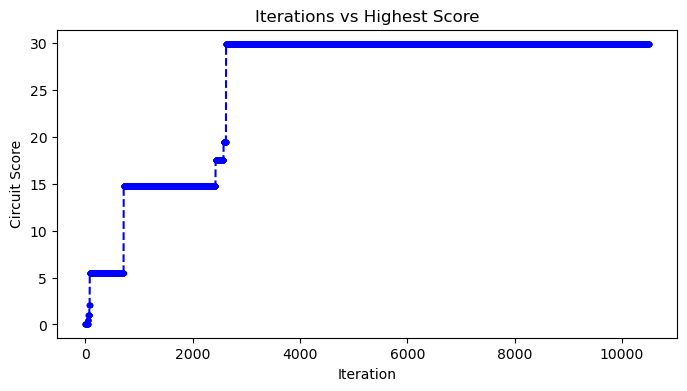

Run time: 536.0431972909719


Optimizing: 100%|██████████| 10500/10500 [09:01<00:00, 19.40it/s]


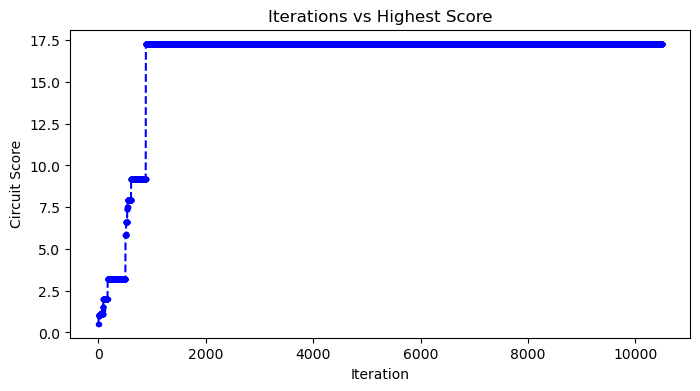

Run time: 541.3223229349824


Optimizing: 100%|██████████| 10500/10500 [09:03<00:00, 19.33it/s]


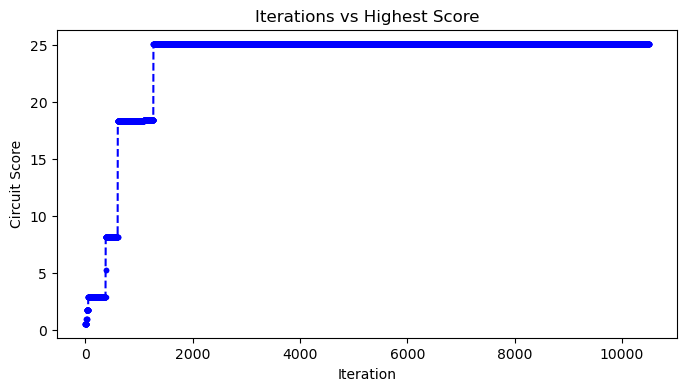

Run time: 543.4820278900443


Optimizing: 100%|██████████| 10500/10500 [09:16<00:00, 18.86it/s]


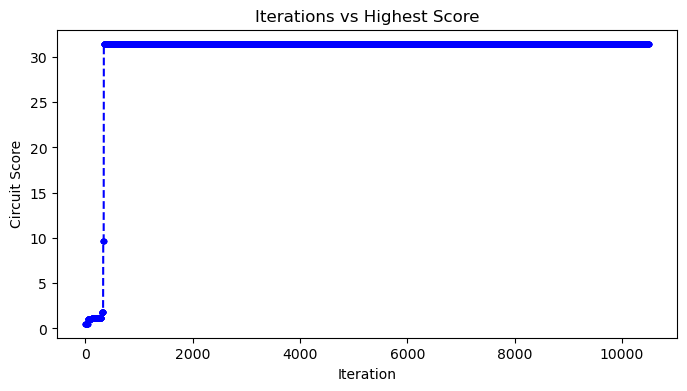

Run time: 557.0518837490818


Optimizing: 100%|██████████| 10500/10500 [09:05<00:00, 19.23it/s]


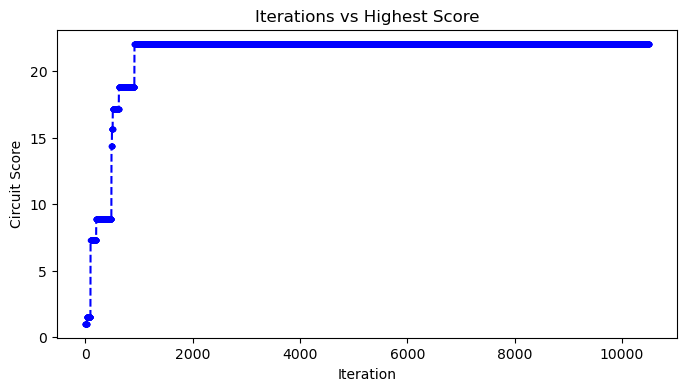

Run time: 546.2027908409946


Optimizing: 100%|██████████| 10500/10500 [09:25<00:00, 18.56it/s]


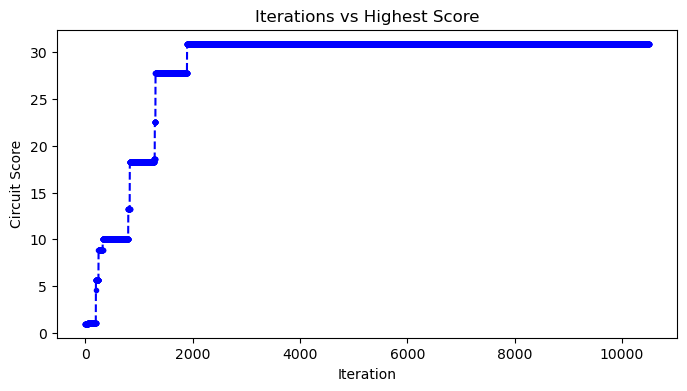

Run time: 566.1708944709972


Optimizing: 100%|██████████| 10500/10500 [09:17<00:00, 18.84it/s]


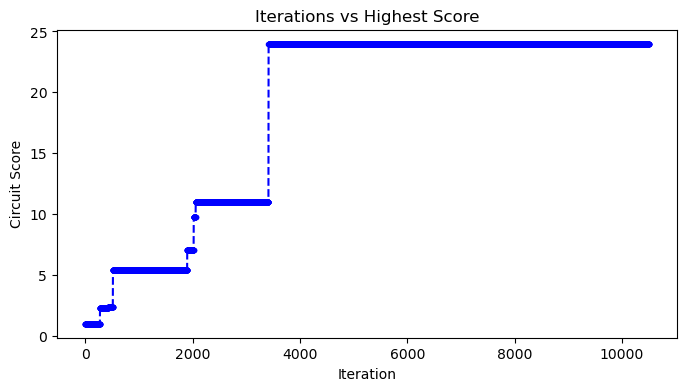

Run time: 557.5652992939577


Optimizing: 100%|██████████| 10500/10500 [09:19<00:00, 18.77it/s]


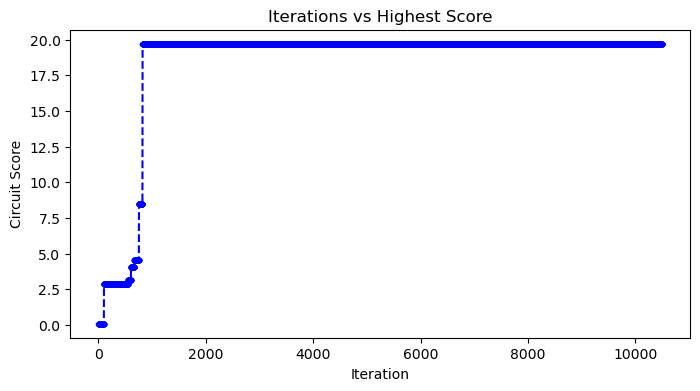

Run time: 559.6883544779848


Optimizing: 100%|██████████| 10500/10500 [08:59<00:00, 19.45it/s]


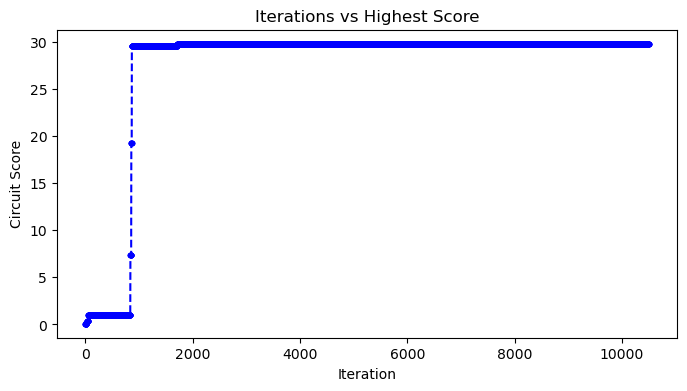

Run time: 540.0936885878909


Optimizing: 100%|██████████| 10500/10500 [09:38<00:00, 18.15it/s]


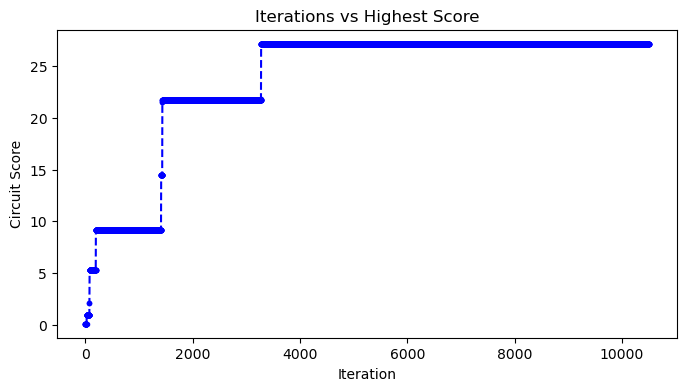

Run time: 578.9680362250656


Optimizing: 100%|██████████| 10500/10500 [09:30<00:00, 18.42it/s]


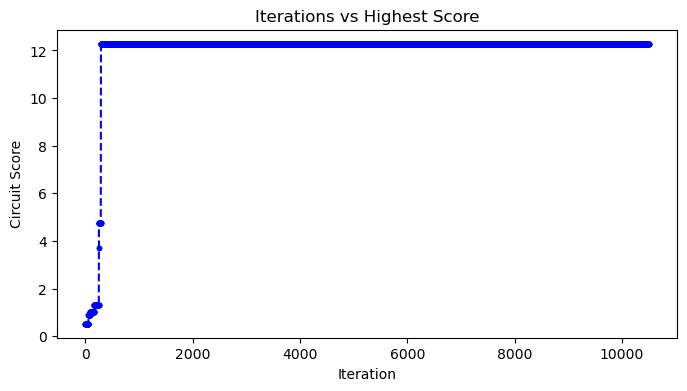

Run time: 570.3390877619386


Optimizing: 100%|██████████| 10500/10500 [09:40<00:00, 18.08it/s]


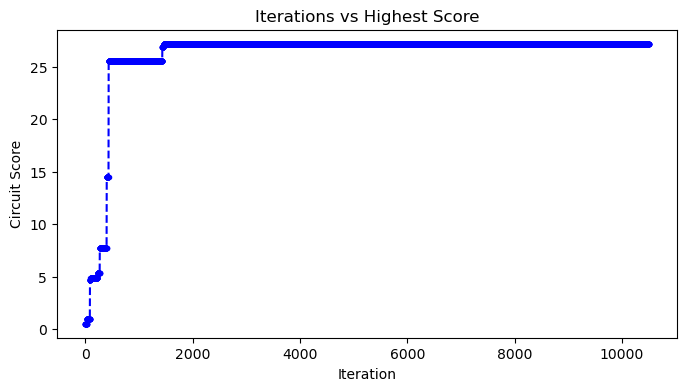

Run time: 581.9072728960309


Optimizing: 100%|██████████| 10500/10500 [09:27<00:00, 18.49it/s]


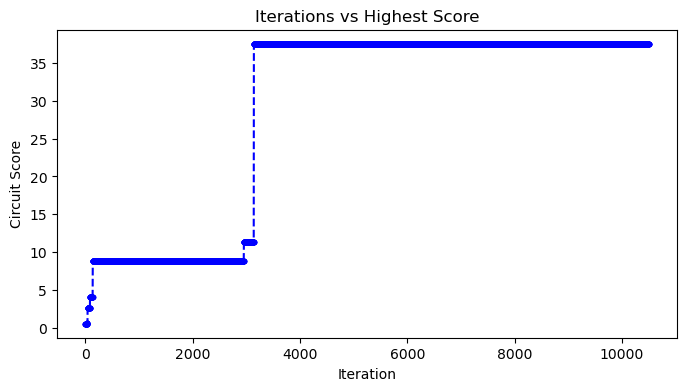

Run time: 568.1489298130618


Optimizing: 100%|██████████| 10500/10500 [08:40<00:00, 20.16it/s]


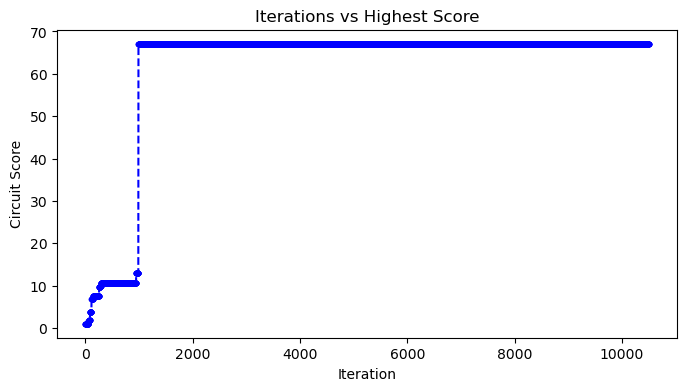

Run time: 521.171167974011


Optimizing: 100%|██████████| 10500/10500 [08:51<00:00, 19.75it/s]


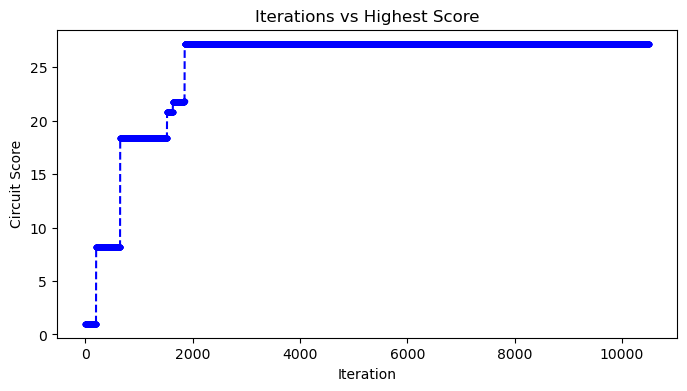

Run time: 531.826110605034


Optimizing: 100%|██████████| 10500/10500 [09:30<00:00, 18.39it/s]


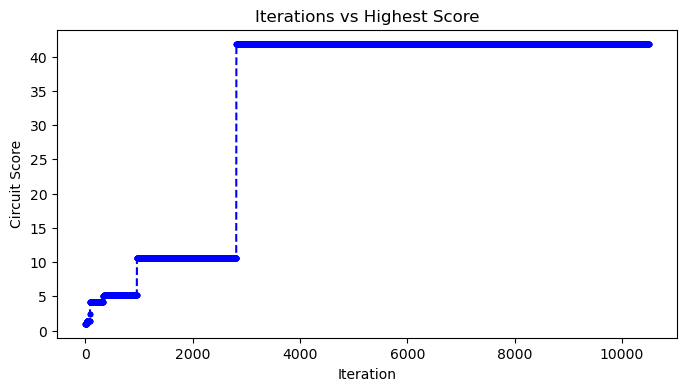

Run time: 571.060010524001


Optimizing: 100%|██████████| 10500/10500 [09:16<00:00, 18.86it/s]


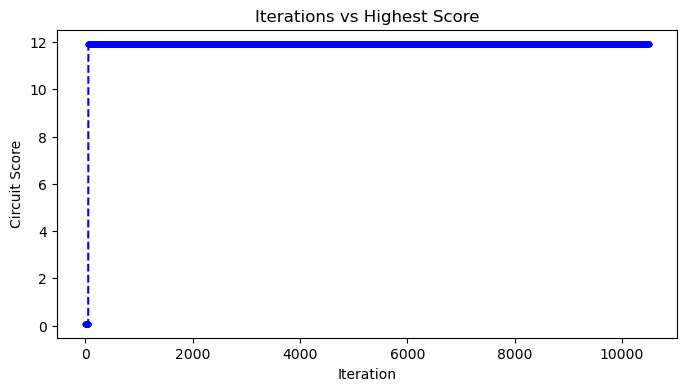

Run time: 557.0252735039685


Optimizing: 100%|██████████| 10500/10500 [08:44<00:00, 20.03it/s]


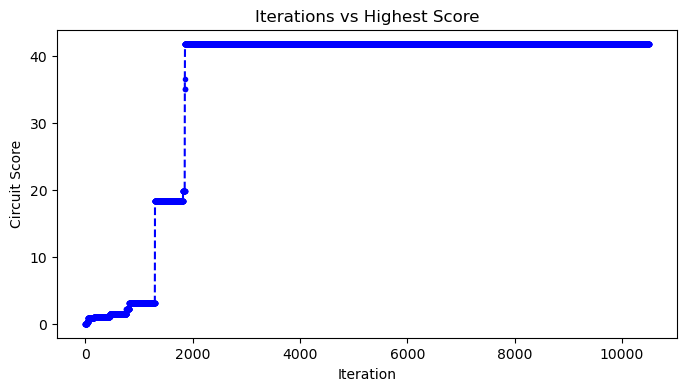

Run time: 524.4587494879961


Optimizing: 100%|██████████| 10500/10500 [08:54<00:00, 19.65it/s]


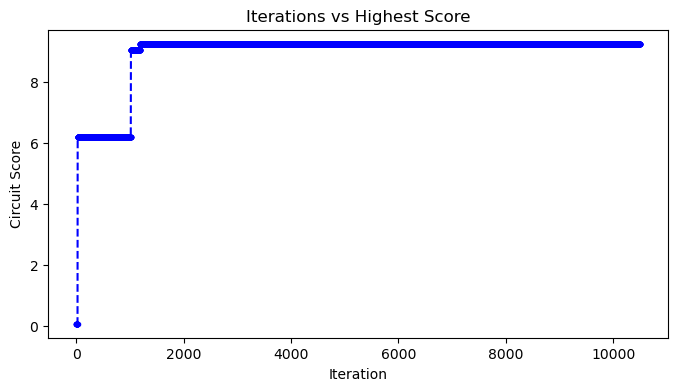

Run time: 534.6302968970267


Optimizing: 100%|██████████| 10500/10500 [09:02<00:00, 19.34it/s]


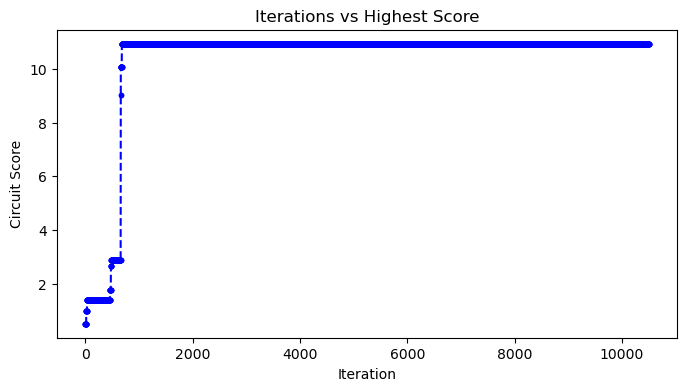

Run time: 543.2328534440603


Optimizing: 100%|██████████| 10500/10500 [08:37<00:00, 20.29it/s]


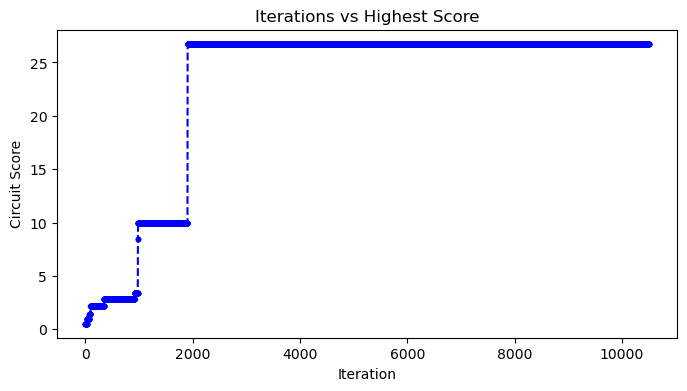

Run time: 517.7282263539964


Optimizing: 100%|██████████| 10500/10500 [09:13<00:00, 18.98it/s]


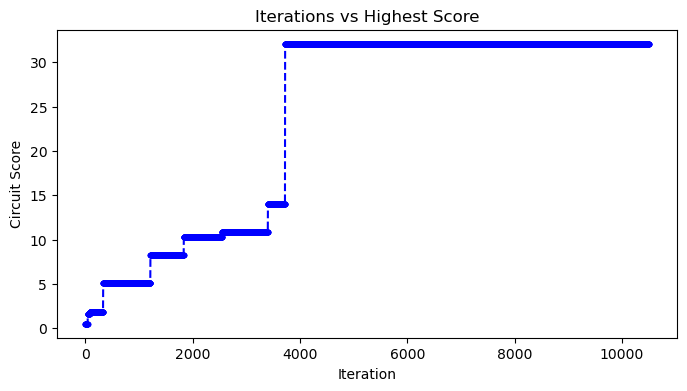

Run time: 553.5098393419757


In [32]:
import os, json, math, random, itertools
import numpy as np
import pandas as pd
from datetime import datetime

MINTEMP = 1e-3  
MAXTEMPS = [1, 10, 100]  
steps = round(total*(1-0.02))
T0_steps = round(total*(0.02))
N_SEEDS = 3
N_INITIALS = 3

results_csv = "sa_sweep_results.csv"
solutions_json = "sa_sweep_solutions.json"   # to store full optimal solutions

# ----------------------------------------------------
# Draw N_SEEDS random seeds (independent of initial states)
# ----------------------------------------------------
seeds = [int.from_bytes(os.urandom(4), "little") for _ in range(N_SEEDS)]

# ----------------------------------------------------
# Precompute N_INITIALS random initial solutions ONCE so that
# all seeds test the SAME 3 initial states.
# Use a dedicated RNG state to avoid coupling with `seeds`.
# ----------------------------------------------------
tmp_seed_for_initials = int.from_bytes(os.urandom(4), "little")
random.seed(tmp_seed_for_initials)
np.random.seed(tmp_seed_for_initials)

initial_solutions = []
for i in range(N_INITIALS):
    init_sol = random_part_selection(postech_v1_hill_function_parameters, gate_count)
    initial_solutions.append(init_sol)

# -------------------------------------------------------
# Run sweep: for each seed × initial_solution × MAXTEMP
# -------------------------------------------------------
rows = []
solutions_store = []  # list of dicts (seed, init_id, maxtemp, solution list)

top_circuit_score = -float("inf")
top_toxicity_score = None
top_solution = None
top_meta = None

run_counter = 0

for seed in seeds:
    # set PRNGs for this run (affects SA stochasticity, not the initial_solutions)
    random.seed(seed)
    np.random.seed(seed)

    for init_id, initial_solution in enumerate(initial_solutions):
        for maxt in MAXTEMPS:
            run_counter += 1
            
            sa_start_time = time.perf_counter()

            optimized_score, optimal_toxicty, optimal_solution = simulated_annealing_cello2(
                adj_matrix,
                initial_solution,
                maxt, MINTEMP,
                steps, T0_steps,
                input_signals_list_small_molecules,
                input_signals_list_binary,
                postech_v1_hill_function_parameters,
                gate_toxicity_df,
                D_GROWTH_THRESHOLD=0.75,
                plot=True  # keep off for batch
            )
            
            sa_end_time = time.perf_counter()
            
            sa_run_time = sa_end_time - sa_start_time
            print(f"Run time: {sa_run_time}")

            # Save a compact row for CSV
            rows.append({
                "run_id": run_counter,
                "seed": seed,
                "initial_id": init_id,         # 0..2
                "MAXTEMP": maxt,
                "MINTEMP": MINTEMP,
                "steps": steps,
                "T0_steps": T0_steps,
                "optimized_score": optimized_score,
                "optimal_toxicity": optimal_toxicty,
            })

            # Save the full optimal solution separately (JSON)
            solutions_store.append({
                "run_id": run_counter,
                "seed": seed,
                "initial_id": init_id,
                "MAXTEMP": maxt,
                "MINTEMP": MINTEMP,
                "optimal_solution": optimal_solution,  # list-like
            })

            # Track global best
            if optimized_score > top_circuit_score:
                top_circuit_score = optimized_score
                top_toxicity_score = optimal_toxicty
                top_solution = optimal_solution
                top_meta = {
                    "seed": seed,
                    "initial_id": init_id,
                    "MAXTEMP": maxt,
                    "MINTEMP": MINTEMP,
                }




In [ ]:
# --------------------------------
# Save results
# --------------------------------
df = pd.DataFrame(rows)
df["timestamp"] = datetime.now().isoformat(timespec="seconds")
df.to_csv(results_csv, index=False)

with open(solutions_json, "w") as f:
    json.dump({
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "solutions": solutions_store,
        "best_overall": {
            "optimized_score": top_circuit_score,
            "optimal_toxicity": top_toxicity_score,
            "meta": top_meta,
            "optimal_solution": top_solution,
        }
    }, f, indent=2)

print(f"Saved run table to: {results_csv}")
print(f"Saved solutions to: {solutions_json}")
print("Best overall:")
print("  score:", top_circuit_score)
print("  tox:", top_toxicity_score)
print("  meta:", top_meta)

In [33]:
G = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, top_solution) 
print("Synthetic gene circuit")
#draw_network_with_colors_and_labels_from_G(G)

expected_logic_current = simulate_signal_propagation_binary(G, input_signals_list_binary)
actual_logic_current = simulate_signal_propagation(G, input_signals_list_small_molecules)
circuit_score_current = calculate_circuit_score(expected_logic_current, actual_logic_current)
toxicity_score_current, detailed_results = calculate_toxicity_score(input_signals_list_small_molecules, G, gate_toxicity_df)
print(circuit_score_current)
print(toxicity_score_current)

Synthetic gene circuit
67.10547087790754
0.7534674525577123


In [34]:
plot_circuit_with_parts_layered(G, show_in_notebook=True, notebook_width = 500, save = False) 
result = validate_dag(G, 1, raise_on_error=True, plot_on_error=True)
result

{'ok': True, 'inputs': [0, 1, 2], 'outputs': [3], 'errors': [], 'warnings': []}

In [ ]:
t_total_end = time.perf_counter()
    
total_time = t_total_end - t_total_start

print(total_time)

In [30]:
Gtest = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, [11,  1, 15, 19,  2, 13]) 
print("Synthetic gene circuit")
#draw_network_with_colors_and_labels_from_G(G)

expected_logic_current = simulate_signal_propagation_binary(Gtest, input_signals_list_binary)
actual_logic_current = simulate_signal_propagation(Gtest, input_signals_list_small_molecules)
circuit_score_current = calculate_circuit_score(expected_logic_current, actual_logic_current)
toxicity_score_current, detailed_results = calculate_toxicity_score(input_signals_list_small_molecules, Gtest, gate_toxicity_df)
print(circuit_score_current)
print(toxicity_score_current)


Synthetic gene circuit
67.10547087790754
0.7534674525577123
